<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-12-16 19:43:36--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2019-12-16 19:43:36 (18.0 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

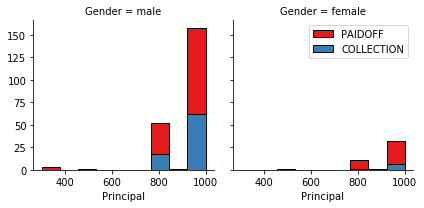

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

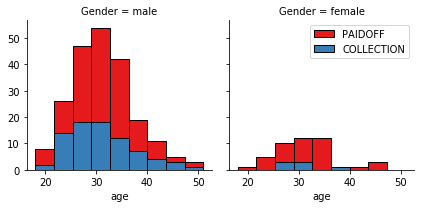

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

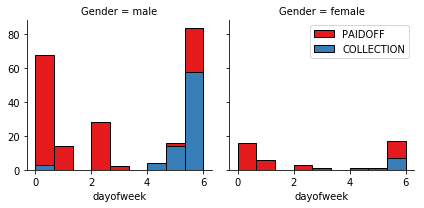

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# Training of the loan_train.csv dataset

In [20]:
# Create the test/train data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ("Train set", X_train.shape,  y_train.shape)
print ("Test set:", X_test.shape,  y_test.shape)

Train set (276, 8) (276,)
Test set: (70, 8) (70,)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [21]:
# Import the KNN Classifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Loop the Classifier to find the best K for the model
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_acc)
knnbest = mean_acc.argmax()+1
print("Best KNN Neighbor: ",knnbest)
print("Best KNN Accuracy: ",mean_acc.max())

[0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286]
Best KNN Neighbor:  7
Best KNN Accuracy:  0.7857142857142857


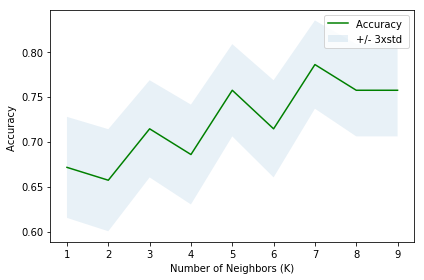

In [22]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [23]:
# Get the F1-Score and the Jaccard score for KNN with 7 Neigbors
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
yhat=neigh.predict(X_test)
print("F1-Score: ",f1_score( y_test, yhat, average='weighted'))
print("Jaccard Score: ",jaccard_similarity_score(y_test, yhat))

F1-Score:  0.7766540244416351
Jaccard Score:  0.7857142857142857


# Decision Tree

In [24]:
# Use the train/test split from the Training section as described below:
# train_test_split( X, y, test_size=0.2, random_state=4)
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
loanTree.fit(X_train,y_train)
yhatTree = loanTree.predict(X_test)

In [25]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("Decision Tree Accuracy: ", metrics.accuracy_score(y_test, yhatTree))

Decision Tree Accuracy:  0.7571428571428571


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



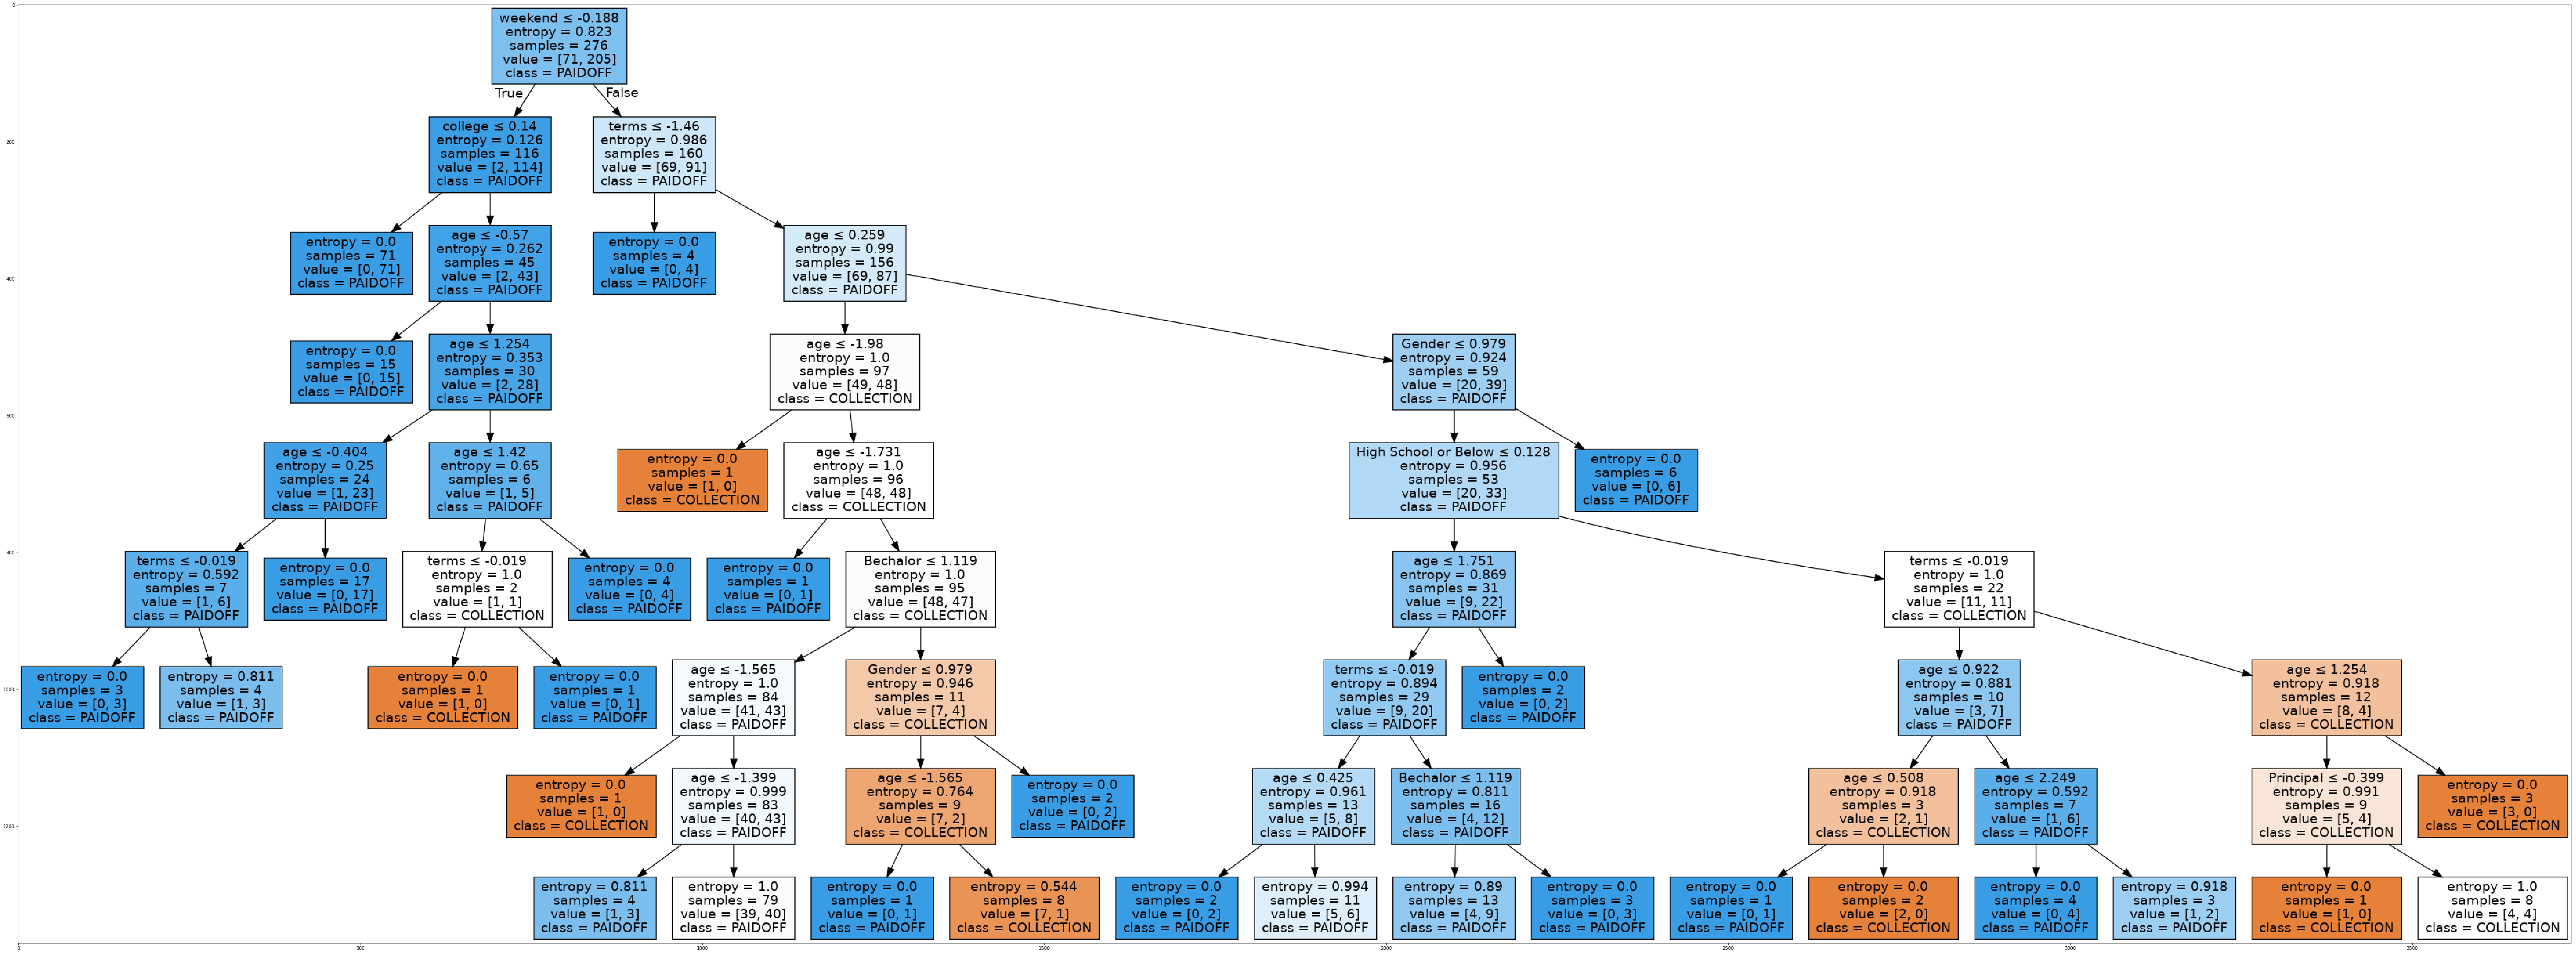

In [26]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

%matplotlib inline
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns[:]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

In [27]:
# Get the F1-Score and the Jaccard score for Decision Tree
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
print("F1-Score: ",f1_score( y_test, yhatTree, average='weighted'))
print("Jaccard Score: ",jaccard_similarity_score(y_test, yhatTree))

F1-Score:  0.6978810663021189
Jaccard Score:  0.7571428571428571


# Support Vector Machine

In [29]:
from sklearn import svm

knls = ['linear', 'poly', 'rbf', 'sigmoid']
mean_accuracy = np.zeros((len(knls)))
for kernel in knls:
    svm_clf = svm.SVC(kernel=kernel, gamma='auto')
    svm_clf.fit(X_train, y_train)
    svm_predict = svm_clf.predict(X_test)
    mean_accuracy[knls.index(kernel)] = metrics.accuracy_score(y_test, svm_predict)
    
print("The accuracy for the Linear kernel was: ", mean_accuracy[0])
print("The accuracy for the Polynomial kernel was: ", mean_accuracy[1])
print("The accuracy for the Radial Bias Function (RBF) kernel was: ", mean_accuracy[2])
print("The accuracy for the Sigmoid kernel was: ", mean_accuracy[3])
print("\n")
print("The best SVM accuracy is: ", mean_accuracy.max())

The accuracy for the Linear kernel was:  0.7857142857142857
The accuracy for the Polynomial kernel was:  0.7714285714285715
The accuracy for the Radial Bias Function (RBF) kernel was:  0.7428571428571429
The accuracy for the Sigmoid kernel was:  0.7428571428571429


The best SVM accuracy is:  0.7857142857142857


In [30]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools
clf = svm.LinearSVC(random_state=7)
#svm.SVC(kernel='linear')
clf.fit(X_train, y_train) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=7, tol=0.0001,
     verbose=0)

In [31]:
yhat = clf.predict(X_test)
yhat [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [32]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
print("F1-Score: ",f1_score(y_test, yhat, average='weighted'))
print("Jaccard Score: ",jaccard_similarity_score(y_test, yhat))

F1-Score:  0.6953867388649997
Jaccard Score:  0.7285714285714285


# Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)

In [34]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.5034238 , 0.4965762 ],
       [0.45206111, 0.54793889],
       [0.30814132, 0.69185868],
       [0.34259428, 0.65740572],
       [0.32025894, 0.67974106],
       [0.31680537, 0.68319463],
       [0.48830185, 0.51169815],
       [0.47823073, 0.52176927],
       [0.34259428, 0.65740572],
       [0.4934056 , 0.5065944 ],
       [0.33806706, 0.66193294],
       [0.49662231, 0.50337769],
       [0.24891907, 0.75108093],
       [0.3419095 , 0.6580905 ],
       [0.43751789, 0.56248211],
       [0.25760497, 0.74239503],
       [0.52357188, 0.47642812],
       [0.30450278, 0.69549722],
       [0.50166363, 0.49833637],
       [0.3195971 , 0.6804029 ],
       [0.44276988, 0.55723012],
       [0.49410185, 0.50589815],
       [0.51350333, 0.48649667],
       [0.47203498, 0.52796502],
       [0.40944694, 0.59055306],
       [0.50846442, 0.49153558],
       [0.51098415, 0.48901585],
       [0.37457647, 0.62542353],
       [0.50418423, 0.49581577],
       [0.25299635, 0.74700365],
       [0.

In [35]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
print("F1-Score: ",f1_score(y_test, yhat, average='weighted'))
print("Jaccard Score: ",jaccard_similarity_score(y_test, yhat))

F1-Score:  0.6670522459996144
Jaccard Score:  0.6857142857142857


In [36]:
from sklearn.metrics import log_loss
print("Log Loss: ",log_loss(y_test, yhat_prob))

Log Loss:  0.5772287609479654


# Model Evaluation using Test set

In [37]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [38]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-12-16 20:09:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-12-16 20:09:11 (281 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [39]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Data Cleanup of Test set

In [40]:
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X = Feature

testy = test_df['loan_status'].values

testX = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


### Training of Test set

In [41]:
# Create the test/train data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( testX, testy, test_size=0.2, random_state=4)
print ("Train set", X_train.shape,  y_train.shape)
print ("Test set:", X_test.shape,  y_test.shape)

Train set (43, 8) (43,)
Test set: (11, 8) (11,)


### K Nearest Neighbor (KNN)  on Test set

In [42]:
# Import the KNN Classifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Loop the Classifier to find the best K for the model
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_acc)
knnbest = mean_acc.argmax()+1
print("Best KNN Neighbor for Test set: ",knnbest)
print("Best KNN Accuracy for Test set: ",mean_acc.max())

[0.72727273 0.63636364 0.72727273 0.54545455 0.81818182 0.72727273
 0.81818182 0.63636364 0.90909091]
Best KNN Neighbor for Test set:  9
Best KNN Accuracy for Test set:  0.9090909090909091


In [43]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
neigh = KNeighborsClassifier(n_neighbors = 9).fit(X_train,y_train)
yhat=neigh.predict(X_test)
print("KNN F1-Score for Test set: ",f1_score( y_test, yhat, average='weighted'))
print("KNN Jaccard Score for Test set: ",jaccard_similarity_score(y_test, yhat))

KNN F1-Score for Test set:  0.8658008658008658
KNN Jaccard Score for Test set:  0.9090909090909091


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Decision Tree on Test set

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
loanTree.fit(X_train,y_train)
yhatTree = loanTree.predict(X_test)
print("F1-Score for Test set: ",f1_score( y_test, yhatTree, average='weighted'))
print("Jaccard Score for Test set: ",jaccard_similarity_score(y_test, yhatTree))

F1-Score for Test set:  0.707070707070707
Jaccard Score for Test set:  0.6363636363636364


### Support Vector Machine on Test set

In [48]:
from sklearn import svm

knls = ['linear', 'poly', 'rbf', 'sigmoid']
mean_accuracy = np.zeros((len(knls)))
for kernel in knls:
    svm_clf = svm.SVC(kernel=kernel, gamma='auto')
    svm_clf.fit(X_train, y_train)
    svm_predict = svm_clf.predict(X_test)
    mean_accuracy[knls.index(kernel)] = metrics.accuracy_score(y_test, svm_predict)
    
print("The accuracy for the Linear kernel was: ", mean_accuracy[0])
print("The accuracy for the Polynomial kernel was: ", mean_accuracy[1])
print("The accuracy for the Radial Bias Function (RBF) kernel was: ", mean_accuracy[2])
print("The accuracy for the Sigmoid kernel was: ", mean_accuracy[3])
print("\n")
print("The best SVM accuracy is: ", mean_accuracy.max())

The accuracy for the Linear kernel was:  0.9090909090909091
The accuracy for the Polynomial kernel was:  0.9090909090909091
The accuracy for the Radial Bias Function (RBF) kernel was:  0.9090909090909091
The accuracy for the Sigmoid kernel was:  0.9090909090909091


The best SVM accuracy is:  0.9090909090909091


In [49]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
clf = svm.LinearSVC(random_state=7)
#svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print("F1-Score for Test set: ",f1_score(y_test, yhat, average='weighted'))
print("Jaccard Score for Test set: ",jaccard_similarity_score(y_test, yhat))

F1-Score for Test set:  0.8658008658008658
Jaccard Score for Test set:  0.9090909090909091


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Logistic Regression on Test set

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

print("F1-Score for Test set: ",f1_score(y_test, yhat, average='weighted'))
print("Jaccard Score for Test set: ",jaccard_similarity_score(y_test, yhat))
print("Log Loss for Test set: ",log_loss(y_test, yhat_prob))

F1-Score for Test set:  0.9218500797448166
Jaccard Score for Test set:  0.9090909090909091
Log Loss for Test set:  0.6557331661296548


# Report for loan_train.csv
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7857  | 0.7766   | NA      |
| Decision Tree      | 0.7571  | 0.6979   | NA      |
| SVM                | 0.7286  | 0.6954   | NA      |
| LogisticRegression | 0.6857  | 0.6670   | 0.5772  |

<h3> K Nearest Neighbor appears to be the best model to use </h3>